In [30]:
# Create dataset

import pandas as pd
import tqdm

df = pd.read_csv('./train_filtered.csv')

df.head(5)

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [31]:
df['Genre'].value_counts()

Rock          107019
Pop            86219
Metal          19098
Jazz           13314
Folk            8165
Indie           7240
R&B             2763
Hip-Hop         2238
Electronic      2002
Country         1890
Name: Genre, dtype: int64

In [36]:
df[df['Genre'] == 'Rock']

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
249891,evermore,unbreakable,Rock,en,You're a shooting star That is what you are Yo...
249898,baby animals,life from a distance,Rock,en,Life lives alone on top of a hill Tonight the ...
249908,graham coxon,leave me alone,Rock,en,Too much information for our minds to comprehe...
249909,carbon leaf,clockwork,Rock,en,A monster used to chase me Used to jump from t...


In [57]:
for genre in df['Genre']:
    for i, row in enumerate(df[df['Genre'] == genre].itertuples()):
        print(row.Lyrics)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



As I got on a city bus and found a vacant seat,
I thought I saw my future bride walkin?up the street,
I shouted to the driver "hey conductor, you must slow down.
I think I see her please let me off this bus"
Nadine, honey is that you?
Oh, Nadine
Honey, is that you?
Seems like every time I see you darling you got something else to do.
(Alternate verse: Seems like every time I catch up with you, you're up to
something new)
I saw her from the corner when she turned and doubled back
And started walkin?toward a coffee colored Cadillac
I was pushin?through the crowd to get to where sheæŠ¯ at
And I was campaign shouting like a southern diplomat.
Downtown searching for her, looking all around,
Saw her getting in a yellow cab heading up town.
I caught a loaded taxi, paid up everybodyæŠ¯ tab.
With a twenty-dollar bill, told him "catch that yellow cab."
She moves around like a wave of summer breeze,
Go, driver, go, go, catch her pretty please.
Moving through the traffuc like a mounted cavalier
Le

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [61]:
for genre in df['Genre']:
    for i, row in enumerate(df[df['Genre'] == genre].itertuples()):
        with open(f'./dataset/{genre}/{i}.txt', 'w', encoding='utf-8') as f:
            for line in row.Lyrics.split('\n'):
                f.write(line)

KeyboardInterrupt: 

In [1]:
import os
import re
import string
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
%load_ext tensorboard

In [3]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=num_ns,
              unique=True,
              range_max=vocab_size,
              seed=SEED,
              name="negative_sampling")

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [14]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [15]:
with open(path_to_file) as f: 
    lines = f.read().splitlines()
for line in lines[:20]:
    print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


In [20]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [21]:
text_ds

<FilterDataset shapes: (), types: tf.string>

In [62]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [63]:
vectorize_layer.adapt(df['Lyrics'])

In [64]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'you', 'i', 'to', 'and', 'a', 'me', 'my', 'it', 'in', 'of', 'that', 'your', 'im', 'on', 'all', 'be', 'is']


In [67]:
ds = tf.data.Dataset.from_tensor_slices(df['Lyrics'].values)

In [68]:
# Vectorize the data in text_ds.
text_vector_ds = ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [69]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

249948


In [70]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  10  957   29  290 2491   99  375    1   99    2] => ['it', 'starts', 'with', 'pain', 'followed', 'by', 'hate', '[UNK]', 'by', 'the']
[ 863  166  120  120  166 3463  257   99    2  579] => ['freedom', 'alone', 'again', 'again', 'alone', 'patiently', 'waiting', 'by', 'the', 'phone']
[  1   2 218  13   1   3 857   5   2 574] => ['[UNK]', 'the', 'hand', 'that', '[UNK]', 'you', 'lying', 'to', 'the', 'voice']
[  3  63   3  25  30 117   4 139  28   3] => ['you', 'say', 'you', 'know', 'just', 'who', 'i', 'am', 'but', 'you']
[   9   93   19 1196 1259   56  473  153  764  497] => ['my', 'heart', 'is', 'beating', 'faster', 'cant', 'control', 'these', 'feelings', 'anymore']


In [71]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|█████████████████████████████████████████████████████████████████████████| 249948/249948 [14:30<00:00, 287.07it/s]




targets.shape: (827418,)
contexts.shape: (827418, 5)
labels.shape: (827418, 5)


In [72]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


In [73]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [93]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [94]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [95]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    verbose=1,
    patience=3
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [96]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
808/808 [==============================] - 7s 8ms/step - loss: 1.4385 - accuracy: 0.3948 - lr: 0.0010
Epoch 2/200
808/808 [==============================] - 6s 8ms/step - loss: 1.2489 - accuracy: 0.4939 - lr: 0.0010
Epoch 3/200
808/808 [==============================] - 7s 8ms/step - loss: 1.1558 - accuracy: 0.5417 - lr: 0.0010
Epoch 4/200
808/808 [==============================] - 7s 8ms/step - loss: 1.0879 - accuracy: 0.5743 - lr: 0.0010
Epoch 5/200
808/808 [==============================] - 7s 8ms/step - loss: 1.0330 - accuracy: 0.5995 - lr: 0.0010
Epoch 6/200
808/808 [==============================] - 7s 8ms/step - loss: 0.9864 - accuracy: 0.6202 - lr: 0.0010
Epoch 7/200
808/808 [==============================] - 7s 8ms/step - loss: 0.9457 - accuracy: 0.6383 - lr: 0.0010
Epoch 8/200
808/808 [==============================] - 7s 9ms/step - loss: 0.9096 - accuracy: 0.6541 - lr: 0.0010
Epoch 9/200
808/808 [==============================] - 7s 8ms/step - loss: 0.8772 - accu

808/808 [==============================] - 7s 8ms/step - loss: 0.5110 - accuracy: 0.7947 - lr: 0.0010
Epoch 73/200
808/808 [==============================] - 7s 8ms/step - loss: 0.5102 - accuracy: 0.7948 - lr: 0.0010
Epoch 74/200
808/808 [==============================] - 6s 8ms/step - loss: 0.5094 - accuracy: 0.7951 - lr: 0.0010
Epoch 75/200
808/808 [==============================] - 6s 8ms/step - loss: 0.5087 - accuracy: 0.7952 - lr: 0.0010
Epoch 76/200
808/808 [==============================] - 6s 8ms/step - loss: 0.5080 - accuracy: 0.7953 - lr: 0.0010
Epoch 77/200
808/808 [==============================] - 7s 8ms/step - loss: 0.5073 - accuracy: 0.7954 - lr: 0.0010
Epoch 78/200
808/808 [==============================] - 6s 8ms/step - loss: 0.5066 - accuracy: 0.7956 - lr: 0.0010
Epoch 79/200
808/808 [==============================] - 6s 8ms/step - loss: 0.5059 - accuracy: 0.7957 - lr: 0.0010
Epoch 80/200
808/808 [==============================] - 7s 8ms/step - loss: 0.5052 - accuracy

808/808 [==============================] - 7s 9ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 2.4414e-07
Epoch 134/200
808/808 [==============================] - 7s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 2.4414e-07
Epoch 135/200
808/808 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8160
Epoch 00135: ReduceLROnPlateau reducing learning rate to 1e-07.
808/808 [==============================] - 7s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 2.4414e-07
Epoch 136/200
808/808 [==============================] - 6s 7ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 137/200
808/808 [==============================] - 6s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 138/200
808/808 [==============================] - 7s 8ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 139/200
808/808 [==============================] - 7s 9ms/step - loss: 0.4623 - accuracy: 0.8160 - lr: 1.0000e-07
Epoch 140/200
808/808 [==

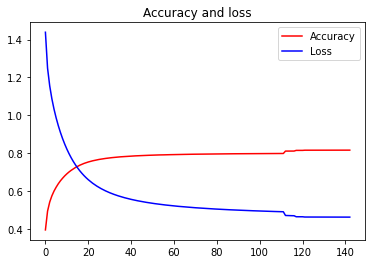

<Figure size 432x288 with 0 Axes>

In [97]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()

plt.show()

In [98]:
word2vec.save('word2vec-second-train')

INFO:tensorflow:Assets written to: word2vec-second-train\assets


In [99]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [100]:
word2vec.get_layer('w2v_embedding')

In [103]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [157]:
x = df['Lyrics'].values
y = np.array(pd.Categorical(pd.factorize(df['Genre'])[0]))

In [178]:
df['int_genre'] = y

Rock: 0
Pop: 1
Metal: 2
Jazz: 3
Folk: 4
Indie: 5
R&B: 6
Hip-Hop: 7
Electronic: 8
Country: 9

In [180]:
df[df['Genre'] == 'Rock']

,Artist,Song,Genre,Language,Lyrics,int_genre
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ...",0
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...,0
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v...",0
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...,0
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...,0
...,...,...,...,...,...,...
249891,evermore,unbreakable,Rock,en,You're a shooting star That is what you are Yo...,0
249898,baby animals,life from a distance,Rock,en,Life lives alone on top of a hill Tonight the ...,0
249908,graham coxon,leave me alone,Rock,en,Too much information for our minds to comprehe...,0
249909,carbon leaf,clockwork,Rock,en,A monster used to chase me Used to jump from t...,0


In [158]:
train_ds = tf.data.Dataset.from_tensor_slices((x, y))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [159]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [160]:
my_word2vec = tf.keras.models.load_model('word2vec-second-train')

In [177]:
# shape of embedding
word2vec.get_layer('w2v_embedding').get_weights()[0].shape

(4096, 128)

In [161]:
class GenreClassifier(tf.keras.Model):
    
    def __init__(self):
        super(GenreClassifier, self).__init__()
        VOCAB_SIZE = 1000        
        self.encoder = encoder
        self.embed = my_word2vec.get_layer('w2v_embedding')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.predict = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.embed(x)
        x = self.lstm(x)
        x = self.dense1(x)
        return self.predict(x)
    

In [167]:
model = GenreClassifier()

In [168]:
model.layers[0].trainable = False
model.layers[1].trainable = False

In [169]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [170]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=42
)

In [187]:
num_data = []
total = len(x)

for genre in df['Genre'].unique():
    num_data.append(len(df[df['Genre'] == genre]))


In [188]:
print(num_data)

[107019, 19098, 86219, 7240, 8165, 2002, 2763, 13314, 2238, 1890]


In [190]:
class_weight = {
    0: 1 - num_data[0] / total,
    1: 1 - num_data[1] / total,
    2: 1 - num_data[2] / total,
    3: 1 - num_data[3] / total,
    4: 1 - num_data[4] / total,
    5: 1 - num_data[5] / total,
    6: 1 - num_data[6] / total,
    7: 1 - num_data[7] / total,
    8: 1 - num_data[8] / total,
    9: 1 - num_data[9] / total
}

In [171]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=40,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    
)

Epoch 1/40
5468/5468 [==============================] - 275s 50ms/step - loss: 1.3945 - accuracy: 0.5040 - val_loss: 1.3295 - val_accuracy: 0.5428 - lr: 1.0000e-04
Epoch 2/40
5468/5468 [==============================] - 270s 49ms/step - loss: 1.3489 - accuracy: 0.5238 - val_loss: 1.3744 - val_accuracy: 0.4925 - lr: 1.0000e-04
Epoch 3/40
5468/5468 [==============================] - 276s 50ms/step - loss: 1.3330 - accuracy: 0.5258 - val_loss: 1.3008 - val_accuracy: 0.5499 - lr: 1.0000e-04
Epoch 4/40
5468/5468 [==============================] - 276s 50ms/step - loss: 1.2786 - accuracy: 0.5550 - val_loss: 1.2543 - val_accuracy: 0.5657 - lr: 1.0000e-04
Epoch 5/40
5468/5468 [==============================] - 269s 49ms/step - loss: 1.2435 - accuracy: 0.5673 - val_loss: 1.2302 - val_accuracy: 0.5736 - lr: 1.0000e-04
Epoch 6/40
5468/5468 [==============================] - 271s 50ms/step - loss: 1.2198 - accuracy: 0.5769 - val_loss: 1.2108 - val_accuracy: 0.5808 - lr: 1.0000e-04
Epoch 7/40
5468/

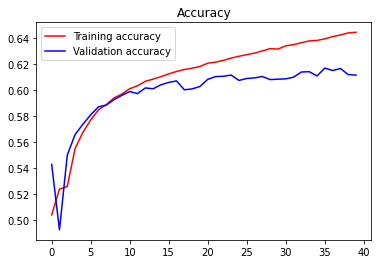

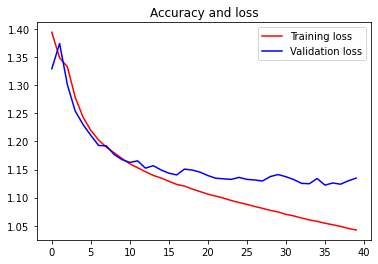

<Figure size 432x288 with 0 Axes>

In [172]:
acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [173]:
model.save('model1')

AssertionError: Tried to export a function which references 'untracked' resource Tensor("11653559:0", shape=(), dtype=resource). TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly.

 Trackable Python objects referring to this tensor (from gc.get_referrers, limited to two hops):
<tf.Variable 'genre_classifier_5/dense_8/kernel:0' shape=(64, 10) dtype=float32>